In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, untar = True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


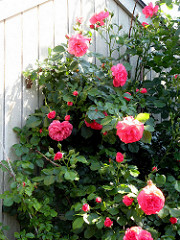

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[10]))

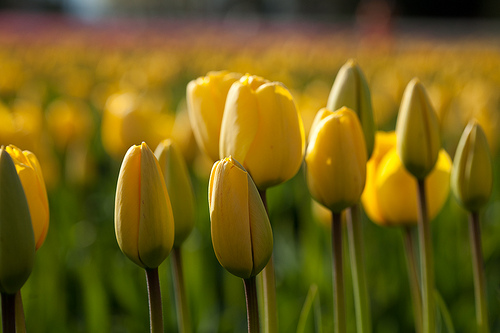

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[20]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "training", seed = 123, image_size = (img_height, img_width), batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "validation", seed = 123, image_size = (img_height, img_width), batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


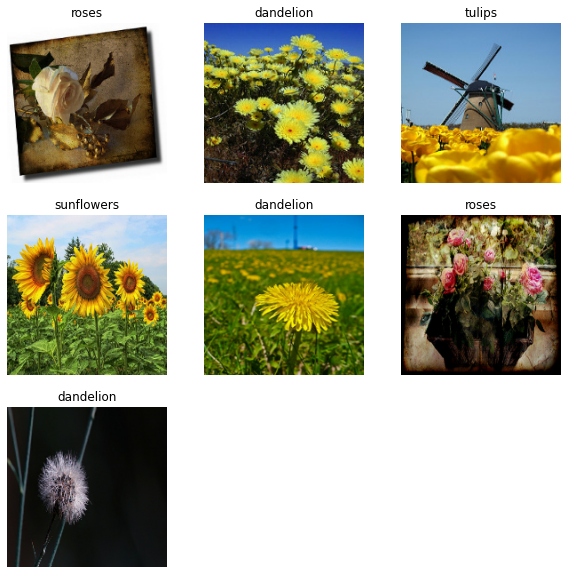

In [10]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
num_classes = 5
model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)), layers.Conv2D(16, 3, padding = 'same', activation = 'relu'), layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), layers.Dense(128, activation = 'relu'), layers.Dense(num_classes)
]) 

In [16]:
model.compile(optimizer ='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [18]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
92/92 [==============================] - 59s 636ms/step - loss: 1.4318 - accuracy: 0.3710 - val_loss: 1.1063 - val_accuracy: 0.5708
Epoch 2/10
92/92 [==============================] - 56s 611ms/step - loss: 1.0625 - accuracy: 0.5830 - val_loss: 0.9137 - val_accuracy: 0.6322
Epoch 3/10
92/92 [==============================] - 56s 614ms/step - loss: 0.7811 - accuracy: 0.7129 - val_loss: 0.9017 - val_accuracy: 0.6417
Epoch 4/10
92/92 [==============================] - 57s 625ms/step - loss: 0.5892 - accuracy: 0.7980 - val_loss: 1.0059 - val_accuracy: 0.6308
Epoch 5/10
92/92 [==============================] - 57s 622ms/step - loss: 0.3714 - accuracy: 0.8806 - val_loss: 1.2425 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 56s 613ms/step - loss: 0.2036 - accuracy: 0.9294 - val_loss: 1.2241 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 56s 613ms/step - loss: 0.1109 - accuracy: 0.9689 - val_loss: 1.4983 - val_accuracy: 0.6512

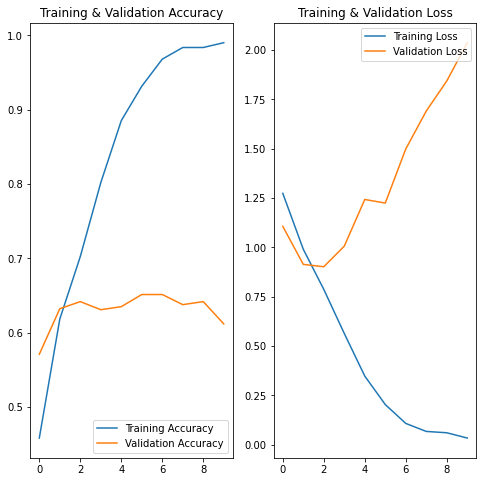

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training & Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape = (img_height, img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

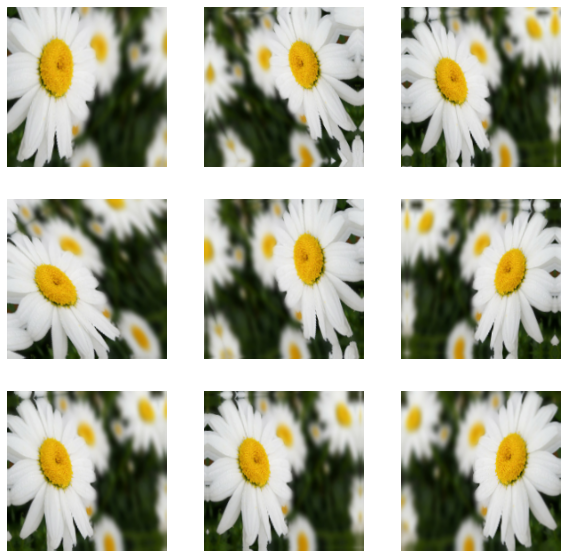

In [21]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer = 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/15
92/92 [==============================] - 67s 717ms/step - loss: 1.6437 - accuracy: 0.3613 - val_loss: 1.0847 - val_accuracy: 0.5681
Epoch 2/15
92/92 [==============================] - 65s 710ms/step - loss: 1.0855 - accuracy: 0.5690 - val_loss: 1.0099 - val_accuracy: 0.5722
Epoch 3/15
92/92 [==============================] - 66s 718ms/step - loss: 0.9834 - accuracy: 0.6122 - val_loss: 0.9261 - val_accuracy: 0.6376
Epoch 4/15
92/92 [==============================] - 75s 819ms/step - loss: 0.9126 - accuracy: 0.6264 - val_loss: 0.9599 - val_accuracy: 0.6240
Epoch 5/15
92/92 [==============================] - 65s 710ms/step - loss: 0.9260 - accuracy: 0.6396 - val_loss: 0.8622 - val_accuracy: 0.6540
Epoch 6/15
92/92 [==============================] - 65s 712ms/step - loss: 0.8262 - accuracy: 0.6973 - val_loss: 0.9877 - val_accuracy: 0.6185
Epoch 7/15
92/92 [==============================] - 65s 710ms/step - loss: 0.7723 - accuracy: 0.7027 - val_loss: 0.9513 - val_accuracy: 0.6431

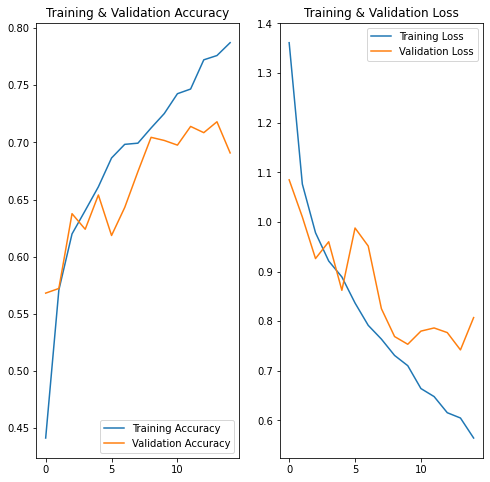

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training & Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training & Validation Loss')
plt.show()

This image most likely belongs to roses with a 66.02 percent confidence.


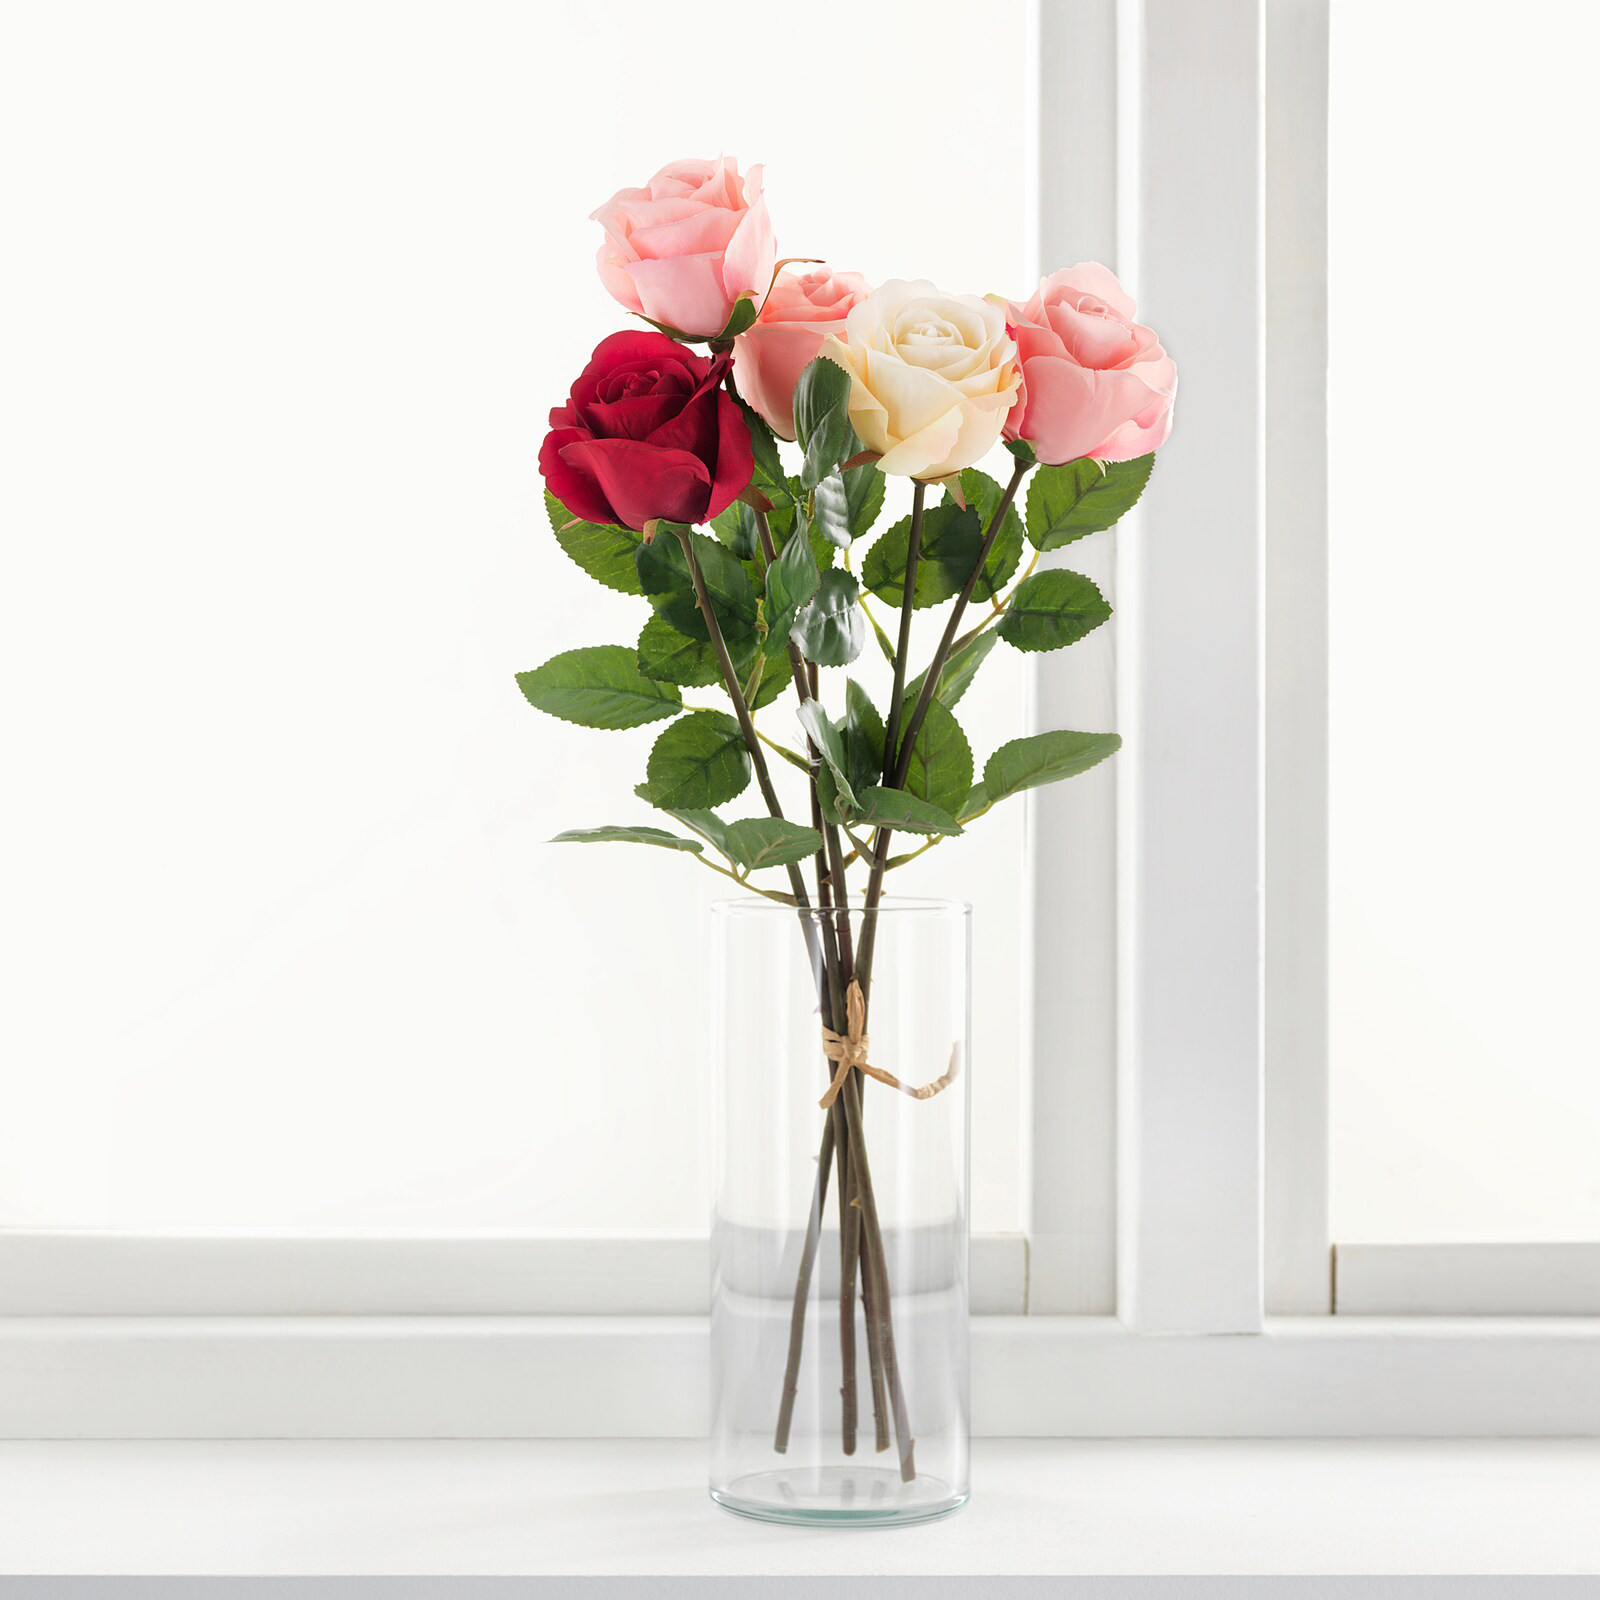

In [27]:
image_url = "https://www.ikea.com/gb/en/images/products/smycka-artificial-flower-rose-red__0902944_PE596726_S5.JPG?f=sg"
image_path = tf.keras.utils.get_file('test_image', origin = image_url)
img = keras.preprocessing.image.load_img(
    image_path, target_size = (img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(image_path)